In [1]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 26px;
</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2023-09-22 17:03:10.135384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 17:03:10.269605: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 17:03:12.010525: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-22 17:03:12.010595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: de

## Parameter data

In [5]:
import numpy as np
import os

node_num = 16
training_id = 0
check_point = 250
end_point = 280

folder_path = os.path.join(os.getcwd(), '../learn_output')
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))

weight = np.load(file_path, allow_pickle=True)

x_train_para = weight[:-1,:]
y_train_para = weight[1:,:]

for training_id in range(1, check_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_train_para = np.concatenate((x_train_para, weight[:-1,:]), axis = 0)
    y_train_para = np.concatenate((y_train_para, weight[1:,:]), axis = 0)

training_id = check_point
file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
weight = np.load(file_path, allow_pickle=True)

x_test_para = weight[:-1,:]
y_test_para = weight[1:,:]

for training_id in range(check_point, end_point):
    file_path = os.path.join(folder_path, 'weight50_%d_%d.npy' % (node_num, training_id))
    
    weight = np.load(file_path, allow_pickle=True)
    
    x_test_para = np.concatenate((x_test_para, weight[:-1,:]), axis = 0)
    y_test_para = np.concatenate((y_test_para, weight[1:,:]), axis = 0)


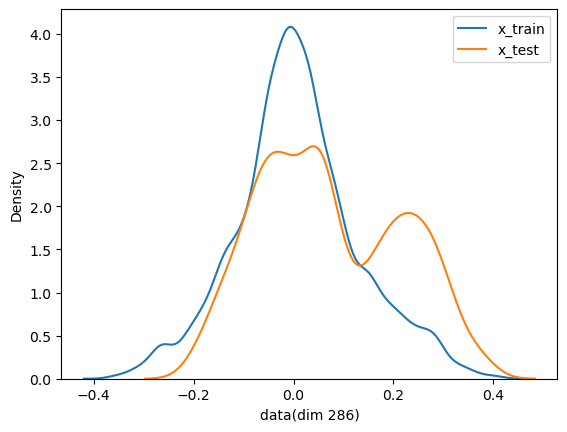

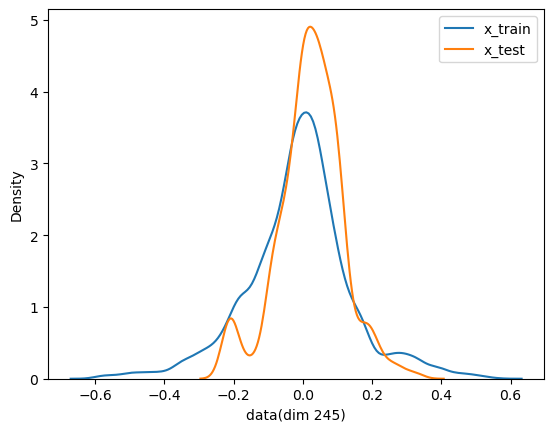

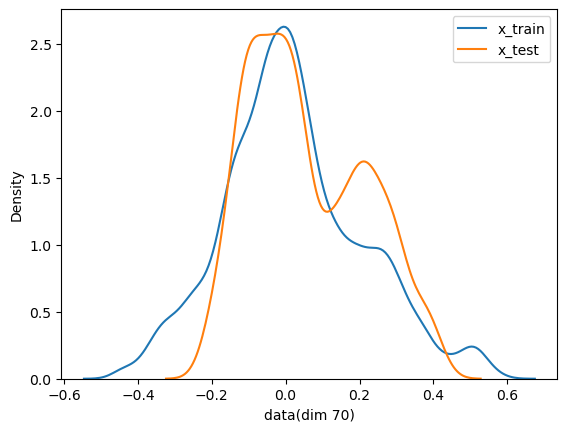

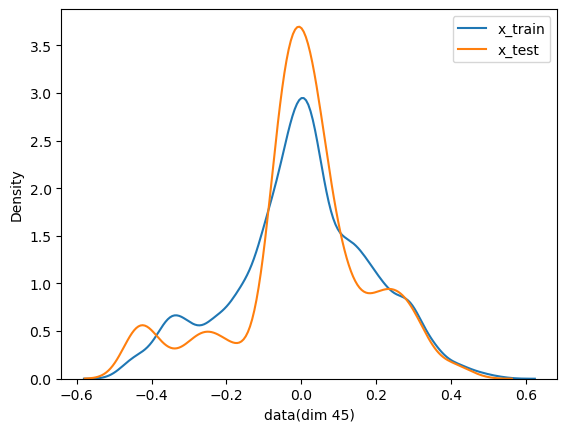

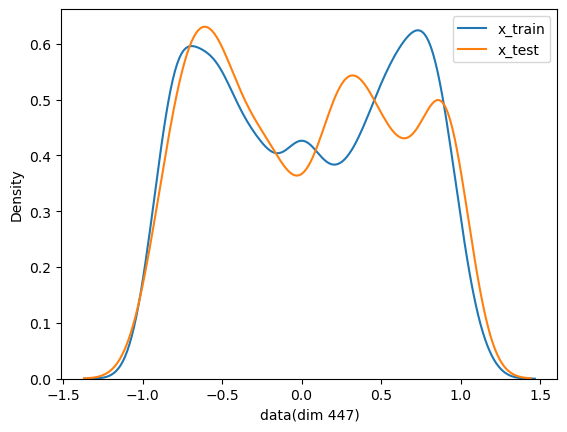

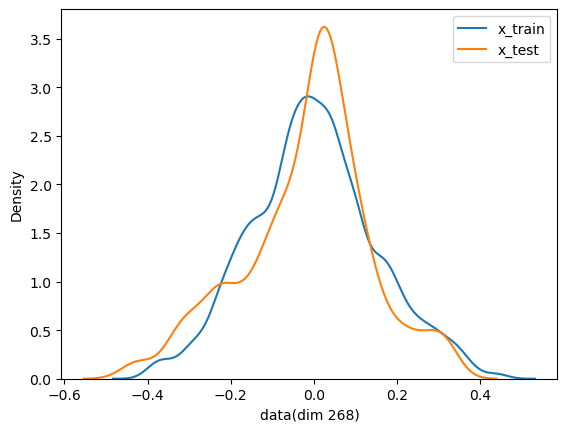

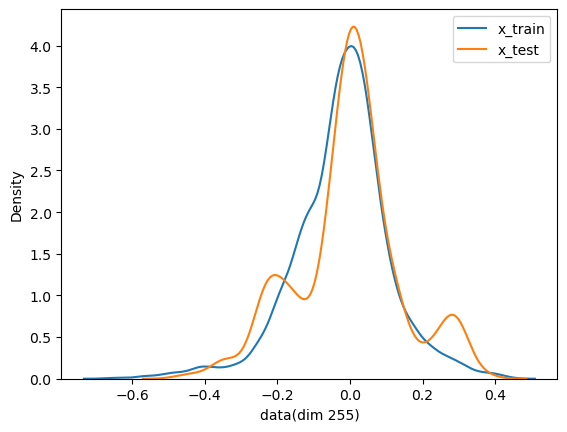

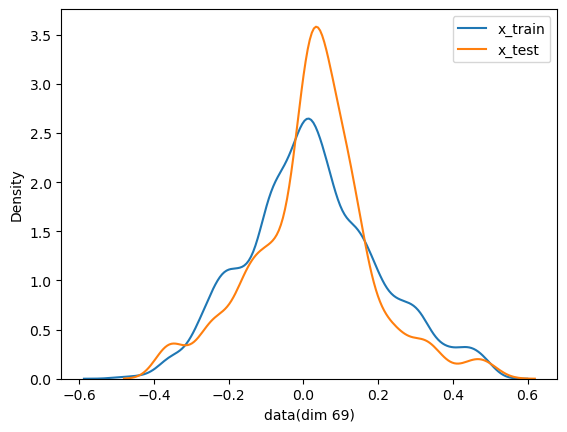

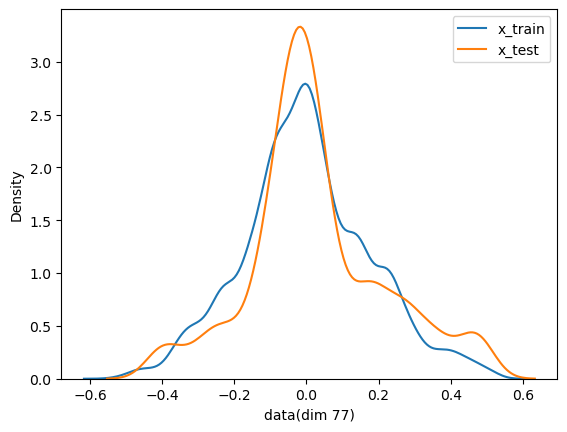

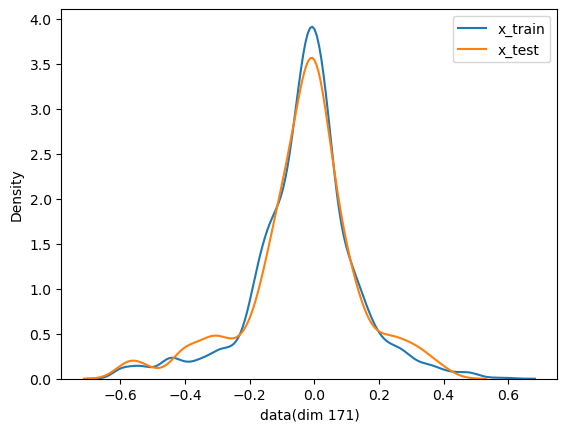

[286, 245, 70, 45, 447, 268, 255, 69, 77, 171]


In [6]:
# Distribution
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

random_numbers = []

for i in range(10):
    random_numbers.append(random.randint(0, 465))
    random_number = random_numbers[-1]
    sns.kdeplot(x_train_para[:, random_number], label = 'x_train')
    sns.kdeplot(x_test_para[:, random_number], label = 'x_test')
    plt.xlabel('data(dim %d)' % random_number)
    plt.legend()
    plt.show()

print(random_numbers)

In [7]:
permuted_indices = np.random.permutation(x_train_para.shape[0])
x_train_para = x_train_para[permuted_indices, :]
y_train_para = y_train_para[permuted_indices, :]


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train_para)
x_train_para_scaled = scaler.transform(x_train_para)
y_train_para_scaled = scaler.transform(y_train_para)
x_test_para_scaled = scaler.transform(x_test_para)
y_test_para_scaled = scaler.transform(y_test_para)

## Mnist Data and Model

In [9]:
from sklearn.decomposition import PCA

# Load MNIST data.
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()

# Preprocessing: normalize pixel values to be between 0 and 1.
x_train_mnist = x_train_mnist / 255.0
x_test_mnist = x_test_mnist / 255.0

# Shuffle training data.
shuffle_index = np.random.permutation(len(x_train_mnist))
x_train_mnist, y_train_mnist = x_train_mnist[shuffle_index], y_train_mnist[shuffle_index]

# Convert target labels to binary classification (digit < 5 or digit >= 5).
y_train_mnist = (y_train_mnist < 5)
y_test_mnist = (y_test_mnist < 5)

# Convert labels to one-hot encoding.
y_train_mnist = tf.keras.utils.to_categorical(y_train_mnist)
y_test_mnist = tf.keras.utils.to_categorical(y_test_mnist)

# Instantiate the training dataset.
x_train_mnist = np.reshape(x_train_mnist, (-1, 784))
x_test_mnist = np.reshape(x_test_mnist, (-1, 784))

# Perform PCA to reduce dimensionality of x_train.
pca = PCA(n_components=0.7)  # retain 95% of variance
x_train_reduced_mnist = pca.fit_transform(x_train_mnist.reshape(x_train_mnist.shape[0], -1))
x_test_reduced_mnist = pca.transform(x_test_mnist.reshape(x_test_mnist.shape[0], -1))

In [10]:
x_combined_reduced_mnist = np.concatenate((x_train_reduced_mnist, x_test_reduced_mnist), axis=0)
y_combined_reduced_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

In [11]:
from tensorflow import keras

inputs = keras.Input(shape=(26,), name="digits")
x = keras.layers.Dense(node_num, activation="relu", kernel_initializer="uniform",bias_initializer="uniform")(inputs)
outputs = keras.layers.Dense(2, name="predictions",kernel_initializer="uniform",bias_initializer="uniform")(x)
model_mnist = keras.Model(inputs=inputs, outputs=outputs, name = 'model_mnist')

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Compile the model
model_mnist.compile(optimizer=optimizer, loss=loss_fn,  metrics=["accuracy"])

2023-09-22 17:03:50.019929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model_mnist.summary()

Model: "model_mnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 26)]              0         
                                                                 
 dense (Dense)               (None, 16)                432       
                                                                 
 predictions (Dense)         (None, 2)                 34        
                                                                 
Total params: 466
Trainable params: 466
Non-trainable params: 0
_________________________________________________________________


## Parameter Model

In [13]:
# Build the model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.executing_eagerly()

class DicNN(Layer):
    """
    Trainable disctionries
    """
    
    def __init__(self, n_input, layer_sizes=[128,128,128], n_psi_train=64, **kwargs):
        """_summary_
        Args:
            layer_sizes (list, optional): Number of unit of hidden layer, activation = 'tanh'. Defaults to [64, 64].
            n_psi_train (int, optional): Number of unit of output layer. Defaults to 22.
        """
        super(DicNN, self).__init__(**kwargs)
        self.layer_sizes = layer_sizes
        self.input_layer = Dense(self.layer_sizes[0], name='Dic_input', use_bias=False)
        self.hidden_layers = [Dense(layer_sizes[i], activation='tanh', name='Dic_hidden_%d'%i) for i in range(len(layer_sizes))]        
        self.output_layer = Dense(n_psi_train, name='Dic_output')
        self.n_psi_train = n_psi_train
        self.inv_input_layer = Dense(self.layer_sizes[-1], name = 'Dic_input_inv', use_bias=False)
        self.inv_hidden_layers = [Dense(layer_sizes[-(i+1)], activation='tanh', name='Dic_hidden_%d_inv'%i) for i in range(len(layer_sizes))]
        self.inv_output_layer = Dense(n_input, name = 'Dic_output_inv')
        self.n_input = n_input
        
    def call(self, inputs):
        psi_x_train = self.input_layer(inputs)
        for layer in self.hidden_layers:
            psi_x_train = psi_x_train + layer(psi_x_train)
        outputs = self.output_layer(psi_x_train)
        return outputs
    
    def inv_call(self, inputs):
        x_inv = self.inv_input_layer(inputs)
        for layer in self.inv_hidden_layers:
            x_inv = x_inv + layer(x_inv)
        outputs = self.inv_output_layer(x_inv)
        return outputs
    
    def get_config(self):
        config = super(DicNN, self).get_config()
        config.update({
            'layer_sizes': self.layer_sizes,
            'n_psi_train': self.n_psi_train
        })
        return config

In [69]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer, Subtract
from tensorflow.keras.models import Model

class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, weights_shape, biases_shape, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.weights_shape = weights_shape
        self.biases_shape = biases_shape

    def call(self, x, theta_w, theta_b, m):
        x = tf.cast(x, dtype=tf.float32)
        w = tf.reshape(theta_w, self.weights_shape)
        b = tf.reshape(theta_b, self.biases_shape)
        b_expanded = tf.tile(tf.expand_dims(b, axis=1), [1, m, 1])
        y = tf.matmul(x, w) + b_expanded
        return y

class ModelLayer(tf.keras.layers.Layer):
    def __init__(self, model, data, **kwargs):
        super(ModelLayer, self).__init__(**kwargs)
        self.model = model
        self.data = data
        self.layer_shape = []
        self.layer_size = []
        self.m = np.shape(data)[0]
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                weights_shape = tf.shape(weights[0])
                biases_shape = tf.shape(weights[1])
                target_shapes = [weights_shape, biases_shape]
                target_shapes = [tf.concat([[-1], shape], axis=0) for shape in target_shapes]
                weights_size = tf.size(weights[0]).numpy()
                biases_size = tf.size(weights[1]).numpy()
                self.layer_shape.append(target_shapes)
                self.layer_size.append([weights_size, biases_size])            
            print(self.layer_shape)
            print(self.layer_size)
        
        self.Layers = []
        for shape in self.layer_shape:
            if shape != None:
                self.Layers.append(CustomLayer(shape[0], shape[1]))
                
    def call(self, theta_M):
        index = 0
        y = self.data
                
        # Hidden Layers
        for i in range(len(self.layer_shape) - 1):
#             print(index)
            size = self.layer_size[i]
            theta_w = theta_M[:, index:index + size[0]]
            theta_b = theta_M[:, index + size[0]: index + size[0] + size[1]]
            index += size[0] + size[1]
            y = self.Layers[i].call(y, theta_w, theta_b, self.m)
            y = tf.nn.relu(y)
        
        # Output Layer
        size = self.layer_size[-1]
        size1 = index + size[0]
#         print(size1)
        theta_w = theta_M[:, index:index + size[0]]
        theta_b = theta_M[:, index + size[0]: index + size[0] + size[1]]
        y = self.Layers[-1].call(y, theta_w, theta_b, self.m)
        return y

In [70]:
# layer_f
Layer_f = ModelLayer(model_mnist, x_train_reduced_mnist)

ListWrapper([])
ListWrapper([])
ListWrapper([ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 26, 16], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, 16], dtype=int32)>])])
ListWrapper([ListWrapper([416, 16])])
ListWrapper([ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 26, 16], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1, 16], dtype=int32)>]), ListWrapper([<tf.Tensor: shape=(3,), dtype=int32, numpy=array([-1, 16,  2], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-1,  2], dtype=int32)>])])
ListWrapper([ListWrapper([416, 16]), ListWrapper([32, 2])])


In [71]:
def Build_model(x_train_para = x_train_para, n_psi_train = 64):
    # model_psi
    dic = DicNN(n_input = np.shape(x_train_para)[1], n_psi_train = n_psi_train)
    inputs_x = Input((np.shape(x_train_para)[1],))
    model_psi = Model(inputs = inputs_x, outputs = dic.call(inputs_x), name = 'model_psi')
    
    # model_koopman
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    k_layer = Dense(units = dic.n_psi_train, use_bias=False, name = 'k_layer')
    outputs_x = k_layer(psi_x)
    inputs_y = Input((np.shape(x_train_para)[1],))
    psi_y = model_psi(inputs_y)
    outputs = outputs_x - psi_y
    model_koopman = Model(inputs = [inputs_x, inputs_y], outputs = outputs, name = 'model_koopman')
    
    # model_inverse
    inputs_kpsi = Input((dic.n_psi_train,))
    model_inv_psi = Model(inputs = inputs_kpsi, outputs = dic.inv_call(inputs_kpsi), name = 'model_psi_inv')
    
    # model_predict
    inputs_x = Input((np.shape(x_train_para)[1],))
    psi_x = model_psi(inputs_x)
    psi_x_predict = k_layer(psi_x)
    outputs_predict = model_inv_psi(psi_x_predict)
    model_predict = Model(inputs = inputs_x, outputs = outputs_predict, name = 'model_predict')
    
    # autoencoder
    input_x = tf.keras.layers.Input(shape=(x_train_para.shape[1],))
    psi_x = model_psi(inputs_x)
    x_hat = model_inv_psi(psi_x)
    model_auto = Model(inputs = inputs_x, outputs = x_hat, name = 'model_auto')

    return model_psi, model_koopman, model_inv_psi, model_predict, model_auto

In [72]:
model_psi, model_koopman, model_inv_psi, model_predict, model_auto = Build_model(x_train_para = x_train_para, n_psi_train = 64)

In [78]:
# Create a train_dataset using from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_para, y_train_para))

# Shuffle and batch the dataset (you can adjust batch_size and buffer_size as needed)
batch_size = 1024
buffer_size = 10000
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)

# Optionally, you can prefetch data for faster training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [79]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Define the optimizer
optimizer = Adam(learning_rate=0.001)  # Set the learning rate as needed

# Define the Mean Squared Error loss function
def MeanSquaredError():
    return tf.keras.losses.MeanSquaredError()

# Define the loss function (as you've defined previously)
lambda_1 = 1.0
lambda_2 = 2.0
lambda_3 = 3.0

# Get the list of trainable variables
trainable_variables = model_koopman.trainable_variables + model_predict.trainable_variables + model_auto.trainable_variables

# Define a function to compute and apply gradients
@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        # Calculate the loss
        koopman_loss = MeanSquaredError()(tf.zeros_like(model_psi(x_data)), model_koopman([x_data, y_data]))
        predicted_y = Layer_f(model_predict(x_data))
        lambda_2_loss = MeanSquaredError()(predicted_y, Layer_f(y_data))
        autoencoder_loss = MeanSquaredError()(Layer_f(model_auto(x_data)), Layer_f(x_data))
        total_loss = lambda_1 * koopman_loss + lambda_2 * lambda_2_loss + lambda_3 * autoencoder_loss

    # Compute gradients
    gradients = tape.gradient(total_loss, trainable_variables)

    # Apply gradients to update model parameters
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return total_loss

# Perform multiple training epochs
num_epochs = 1000  # Set the number of training epochs as needed
for epoch in range(num_epochs):
    total_loss_epoch = 0.0  # Initialize total_loss for the epoch
    
    # Iterate over the training data and perform training
    for batch_x_data, batch_y_data in train_dataset:  # Iterate according to your dataset definition
        loss = train_step(batch_x_data, batch_y_data)
        total_loss_epoch += loss.numpy()

    # Calculate the average loss for the epoch
    avg_loss_epoch = total_loss_epoch / len(train_dataset)
    
    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss_epoch}")

# Once training is complete, your model is trained


Epoch 1/1000, Loss: 52.67842777570089
Epoch 2/1000, Loss: 10.203835924466452
Epoch 3/1000, Loss: 6.342342535654704
Epoch 4/1000, Loss: 5.6014747222264605
Epoch 5/1000, Loss: 4.844394207000732
Epoch 6/1000, Loss: 3.7534457643826804
Epoch 7/1000, Loss: 3.1875989039738974
Epoch 8/1000, Loss: 3.259953955809275
Epoch 9/1000, Loss: 3.2867202361424765
Epoch 10/1000, Loss: 2.948906362056732
Epoch 11/1000, Loss: 2.3931493163108826
Epoch 12/1000, Loss: 2.1727918883164725
Epoch 13/1000, Loss: 2.1287768880526223
Epoch 14/1000, Loss: 2.2648573021094003


KeyboardInterrupt: 